# Object Detection with PyTorch and DETR

**Author:** Shingo Nakazawa ([@shnakazawa](https://twitter.com/shnakazawa))

**Objective:** This series of notebooks provides baseline codes for Computer Vision (CV) Tasks. The target readers are those who want to try CV competitions and those who want to learn CV methods that can be applied to their duties.

This notebook is the second section of the following:

1. [Image Classification with PyTorch and EfficientNetV2](https://github.com/shnakazawa/computer-vision-baselines/blob/main/1_Classification_PyTorch_EfficientNetV2.ipynb)
1. **Object Detection with PyTorch and DETR**
1. Semantic Segmentation (TBA)

In this notebook, we will create a object detection model using [**Detection Transformer (DETR) architecture**](https://arxiv.org/abs/2005.12872) with [PyTorch](https://pytorch.org/).

DETR is a deep learning model based on the Transformer architecture used for object detection tasks. We will **download a pretrained model provided by the research team using `torch.hub.load()`**.

(While this notebook focuses on using a pre-trained model, subsequent notebooks will cover manually coding models from scratch.)

Please see also [a reference article (in Japanese)](https://zenn.dev/aidemy/articles/30f10cf2c48e6a)


## Dataset

Here, we use the dataset from [Kaggle Global Wheat Detection competition](https://www.kaggle.com/competitions/global-wheat-detection).

**[You can directly run this notebook on Kaggle.](https://www.kaggle.com/shnakazawa/object-detection-with-pytorch-and-detr)**

Alternatively, you can download the dataset and place it as shown below.

```zsh
.
├── This notebook
└── data/
    └── global-wheat-detection/
        ├── train.csv
        ├── train/
        ├── test/
        └── sample_submission.csv
```


## Import Modules

In [1]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
from pathlib import Path
import cv2
from tqdm.notebook import tqdm
from sklearn.model_selection import KFold

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
print(f'Albumentations version {A.__version__}')

PyTorch version 1.13.0
Albumentations version 1.3.0


## Set Configs

Separatelly setting configs such as runnning objectives, file paths, hyperparameters, etc. is helpful in maintain a clear and organized workflow.

In [2]:
KAGGLE = True # True if runnning on Kaggle Notebook. False if else.
RUN_EDA = True
RUN_TRAINING = True
TRAIN_ALL = False # If true, train with all data and output a single model. If False, run cross validation and output multiple models.
FOLD_NUM = 5 # For cross validation
RUN_INFERENCE = False

# Directory setting
if KAGGLE:
    DETR_DIR = '/kaggle/working/detr'
    DATA_DIR = '/kaggle/input/global-wheat-detection/'
    MODEL_DIR = '/kaggle/working/'
    IMG_SAVE_DIR = '/kaggle/working/'
else:
    DETR_DIR = 'detr/'
    DATA_DIR = 'data/global-wheat-detection/'
    MODEL_DIR = 'models/global-wheat-detection/'
    CSV_SAVE_DIR = 'outputs/global-wheat-detection/csv/'
    IMG_SAVE_DIR = 'outputs/global-wheat-detection/img/'

# PyTorch variables
LOCAL_DEVICE = 'cpu' # 'cuda', 'cpu', or 'mps'. Depends on your PC. Is used only when KAGGLE = False.
SEED = 42
NUM_CLASSES = 2 # Wheat + background = 2 classes
# NUM_QUERIES = 100 # How many bboxes shall the model output per image. In this notebook, it is defined based on the num of bboxes in training data
NUM_WORKERS = 2
BATCH_SIZE = 16
LR = 2e-5
EPOCHS = 3
NULL_CLASS_COEF = 0.5
GAMMA = 0.1
THRESHOLD = 0.3 # Threshold for bbox prediction score

## Import DETR Modules

To use DETR model and its unique loss function, close its repository. 

In [3]:
if os.path.exists(DETR_DIR) == False:
    !git clone https://github.com/facebookresearch/detr.git

import sys
sys.path.append(DETR_DIR)

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

Cloning into 'detr'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 263 (delta 0), reused 1 (delta 0), pack-reused 260
Receiving objects: 100% (263/263), 12.88 MiB | 12.42 MiB/s, done.
Resolving deltas: 100% (120/120), done.


## Define Helper Functions

Defining reused functions at the top of a Jupyter Notebook can lead to cleaner, more organized, and more efficient code, which can be especially helpful for larger and more complex projects.

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set seed
seed_everything(SEED)


def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")    

    
def load_img(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def group_bboxes(df):
    df_ = df.copy()
    df_['bbox_count'] = 1
    df_ = df_.groupby(['image_id', 'source']).count().reset_index()
    return_df = df_[['image_id', 'source', 'bbox_count']]
    return return_df


def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/
    
    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """    
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result


def normalize_bbox(bboxes, rows, cols):
    """Normalize coordinates of a bounding box. Divide x-coordinates by image width and y-coordinates
    by image height.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    normalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        normalized_bbox = (x_min / cols, y_min / rows, x_max / cols, y_max / rows)
        normalized_bboxes.append(normalized_bbox)
    return normalized_bboxes


def denormalize_bbox(bboxes, rows, cols):
    """Denormalize coordinates of a bounding box. Multiply x-coordinates by image width and y-coordinates
    by image height. This is an inverse operation for :func:`~albumentations.augmentations.bbox.normalize_bbox`.
    Source: https://vfdev-5-albumentations.readthedocs.io/en/docs_pytorch_fix/_modules/albumentations/augmentations/bbox_utils.html
    with minor modification
    """
    denormalized_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        denormalized_bbox = (x_min * cols, y_min * rows, x_max * cols, y_max * rows)
        denormalized_bboxes.append(denormalized_bbox)
    return denormalized_bboxes


def show_validation_score(train_loss_list, valid_loss_list, save=False, save_dir=IMG_SAVE_DIR, save_name='objectdetection_validation_score.png'):
    fig = plt.figure(figsize=(10,10))
    for i in range(FOLD_NUM):
        train_loss = train_loss_list[i]
        valid_loss = valid_loss_list[i]
        
        ax = fig.add_subplot(math.ceil(np.sqrt(FOLD_NUM)), math.ceil(np.sqrt(FOLD_NUM)), i+1, title=f'Fold {i+1}')
        ax.plot(range(EPOCHS), train_loss, c='orange', label='train')
        ax.plot(range(EPOCHS), valid_loss, c='blue', label='valid')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend()
    
    plt.tight_layout()
    if save:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir+save_name)
    else:
        plt.show()

## Load and Reshape a Table

Different formats are used to annotate bounding boxes for object detection tasks, depending on the model. The most common formats are `coco`, `voc-pascal`, and `yolo`, which encode the coordinates in the following ways:

- `coco`: `[x, y, width, height]`, where `x` and `y` represent the upper-left coordinate of the rectangle.
- `voc-pascal`: `[x1, y1, x2, y2]`, where `x1` and `y1` represent the upper-left coordinate of the rectangle, and `x2` and `y2` represent the lower-right coordinate.
- `yolo`: `[x, y, width, height]`, where `x` and `y` represent the center of the rectangle.

In the present dataset, bounding box coordinates are given in the coco format, which is used by the DETR model. To prepare the data for training, we load and reshape the table to match the expected format of the model.

In [5]:
df = pd.read_csv(DATA_DIR + 'train.csv')
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


As you can see, the current dataset has **one bounding box per row** and x, y, width, and height of the bounding box are represented in the single column using list-style formatting.

To better work with the data, we need to **split the values of the bounding box into separate columns**.

In [6]:
# ref: https://www.kaggle.com/code/tanulsingh077/end-to-end-object-detection-with-transformers-detr#Wheat-Detection-Competition-With-DETR
marking = df.copy()
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)
marking.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


Next, let's restructure the data to have **one image per row**, with the number of bounding boxes in each image. This will make it easier to work with the data and feed it into the model.

In [7]:
grouped_df = group_bboxes(marking)
NUM_QUERIES = max(grouped_df['bbox_count']) # How many bboxes shall the model output per image.
grouped_df.head()

,image_id,source,bbox_count
0,00333207f,arvalis_1,55
1,005b0d8bb,usask_1,20
2,006a994f7,inrae_1,25
3,00764ad5d,inrae_1,41
4,00b5fefed,arvalis_3,25


## Exploratory Data Analysis (EDA)

EDA for images is typically simpler than for tabular data.

**Please set `RUN_EDA = True` in the `Set Config` section.**

### Inspect Representative Images

Visually inspecting images is crucial. If the images are noisy or weird, preprocessing may be required before training a model.

944c60a15.jpg
dd5dd0234.jpg
72f8aaa4f.jpg
69595016d.jpg
28b8ba0aa.jpg
2d635716b.jpg


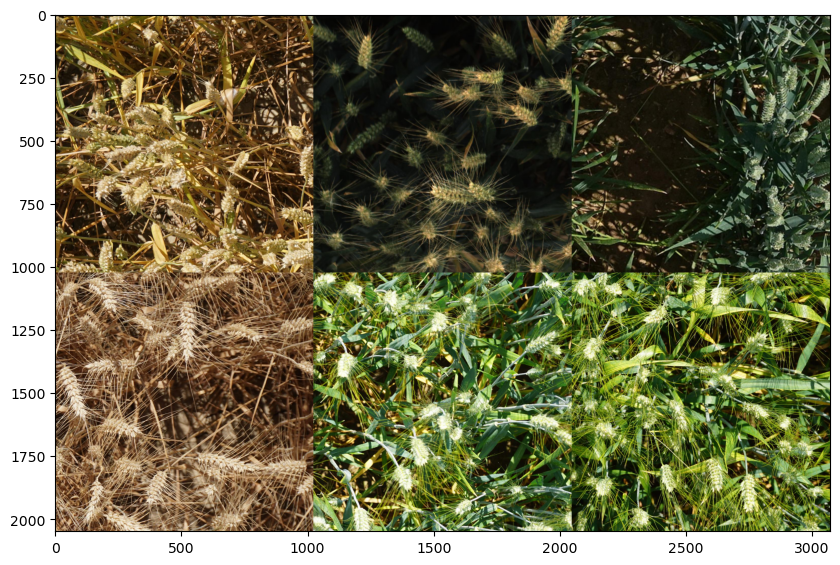

In [8]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train/').glob('*.jpg')
    img_list = []
    for i, img_name in enumerate(img_names):
        img_list.append(load_img(img_name.as_posix()))
        print(img_name.name)
        if i == 5: 
            break
    plt.figure(figsize=(10,10))
    plt.imshow(create_gallery(np.array(img_list), ncols=3))
else:
    print('RUN_EDA is False')

### Check Image Shape

It is also important to check the size and color of the images in the dataset.

Creating histograms can also be helpful.

In [9]:
if RUN_EDA:
    img_shape = set()
    img_ext = set()
    img_names = Path(DATA_DIR+'train/').glob('*')
    pbar = tqdm(img_names, total=len(grouped_df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        img_shape.add(img.shape)
        img_ext.add(img_name.suffix)
    print(f'Image shapes are {img_shape}.')
    print(f'Image extensions are {img_ext}.')

  0%|          | 0/3373 [00:00<?, ?it/s]

Image shapes are {(1024, 1024, 3)}.
Image extensions are {'.jpg'}.


We are confident that all images are 1024 x 1024 RGB jpg.

### Plot histogram of pixel values

Creating a histogram of pixel values can help identify any outlier images (such as those with all zeros).

  0%|          | 0/147793 [00:00<?, ?it/s]

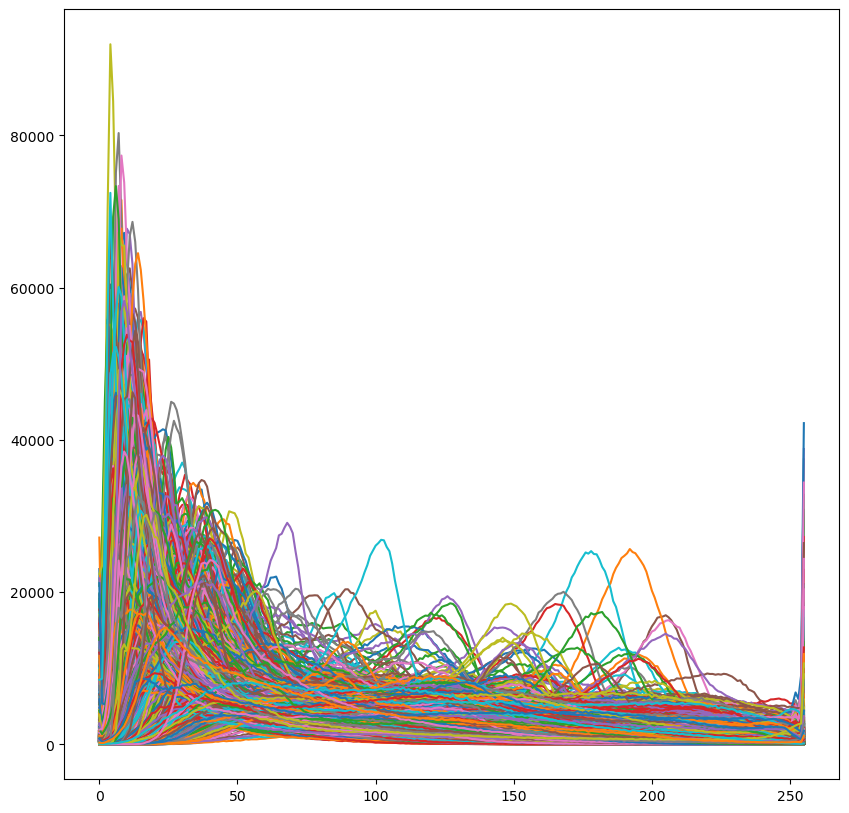

In [10]:
if RUN_EDA:
    img_names = Path(DATA_DIR+'train/').glob('*')
    plt.figure(figsize=(10,10))
    pbar = tqdm(img_names, total=len(grouped_df))
    for img_name in pbar:
        img = load_img(img_name.as_posix())
        hist = cv2.calcHist([img],[0],None,[256],[0,256])
        plt.plot(hist)
    plt.show()
else:
    print('RUN_EDA is False')

The image signals in many images appear dark, while in some images they are saturated.

In this notebook, for sake of simplicity, we will proceed to the next section without any preprocessing.

## Define Model Components

Before training a model using PyTorch, the following steps need to be completed:

1. Define Image Transformation and Augmentation
2. Define the Dataset
3. Define the DataLoader
4. Define the Model

### Define Image Transformation and Augmentation

Before creating the dataset, let's define the transformations and augmentations that will be applied to the images.

**For object detection tasks, the bounding boxes also need to undergo transformations and augmentations.**

To transform the bounding boxes, you can refer to the following:
- [GitHub/albumentations-team/albumentations#spatial-level-transforms](https://github.com/albumentations-team/albumentations#spatial-level-transforms)
- [Albumentations Documentation/Bounding boxes augmentation for object detection](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#bounding-boxes-augmentation)
    - How `min_area` and `min_visibility` work.

In [11]:
# Image Transformation & Augmentation
def transform_train():
    transforms = [
        #A.RandomResizedCrop(512,512,p=1),
        A.Resize(512, 512, p=1),
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
        ], p=0.9),
        A.ToGray(p=0.01),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),   
        ToTensorV2(p=1)
    ]
    bbox_params = A.BboxParams(format='coco', min_area=0, min_visibility=0, label_fields=['labels'])
    return A.Compose(transforms, bbox_params, p=1)


# Validation images undergo only resizing.
def transform_valid():
    transforms = [
        A.Resize(512,512,p=1),
        ToTensorV2(p=1)
    ]
    bbox_params = A.BboxParams(format='coco', min_area=0, min_visibility=0,label_fields=['labels'])
    return A.Compose(transforms, bbox_params, p=1)

### Define the Dataset

In [12]:
# Dataset
class WheatDataset(Dataset):
    def __init__(self, image_ids, dataframe, data_root, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.dataframe = dataframe
        self.data_root = data_root
        self.transforms = transforms

    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, index):
        image_id = self.image_ids[index]
        records = self.dataframe[self.dataframe['image_id'] == image_id]
        # Load images
        image  = load_img(f'{self.data_root}{image_id}.jpg').astype(np.float32)
        image /= 255.0 # normalization

        # bbox and area
        boxes = records[['x', 'y', 'w', 'h']].to_numpy()
        area = boxes[:,2] * boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        labels = np.zeros(len(boxes), dtype=np.int32)

        # Transform images
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']
        
        # Normalizing bboxes
        _,h,w = image.shape
        boxes = normalize_bbox(sample['bboxes'],rows=h,cols=w)
        
        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels, dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        return image, target, image_id

### Define the DataLoader

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))


def create_dataloader(df, marking, trn_idx, val_idx):
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    # Dataset
    train_datasets = WheatDataset(train_['image_id'].to_numpy(), marking, DATA_DIR+'train/', transforms=transform_train())
    valid_datasets = WheatDataset(valid_['image_id'].to_numpy(), marking, DATA_DIR+'train/', transforms=transform_valid())

    # DataLoader
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    return train_loader, valid_loader

### Define Model

In this notebook, we will use a pre-trained DETR model downloaded using `torch.hub.load()`.

- Initial DETR model has 91 (+ 1 background) classes
- Initial DETR model takes in 100 queries = outputs 100 bboxes for every image

Thus, we need to modify these parameters (`NUM_CLASSES`, `NUM_QUERIES`) to match **the number of classes and bounding boxes** in the target dataset.

In [14]:
class DETRModel(nn.Module):
    def __init__(self):
        super(DETRModel,self).__init__()
        self.num_classes = NUM_CLASSES
        self.num_queries = NUM_QUERIES
        
        # Donwload pre-trained model
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features, out_features=self.num_classes)
        self.model.num_queries = self.num_queries
        
    def forward(self,imgs):
        return self.model(imgs)

Define a class for averaging loss,metric,etc over epochs

Source: https://www.kaggle.com/code/tanulsingh077/end-to-end-object-detection-with-transformers-detr#Wheat-Detection-Competition-With-DETR


In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Run Training

To create an effective deep learning model, we need to determine the optimal architecture and hyperparameters. 

One approach for this is to use **cross-validation**, where data is divided into subsets to train and validate the model. Using MLOps tools like [**MLFlow**](https://mlflow.org/) can greatly assist in tracking the performance of the model.

**Once we identify the optimal combination of architecture and hyperparameters**, we can **train the model on all available data**.

It's debatable whether to retrain a single model or use an ensemble of models created during cross-validation. 

- [StackExchange - How to choose a predictive model after k-fold cross-validation?](https://stats.stackexchange.com/questions/52274/how-to-choose-a-predictive-model-after-k-fold-cross-validation)
- [StackOverflow - k-fold cross validation model selection method](https://stackoverflow.com/questions/46860325/k-fold-cross-validation-model-selection-method)

### Cross-Validation

**Before running the following cell, please set `RUN_TRAINING = True` and `TRAIN_ALL = False` in the `Set Config` section.**

Using cuda device
==========Cross Validation Fold 1==========


/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/dropout/cutout.py:51: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,
Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "htt

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

==========Epoch 1 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.5466 - val_loss : 1.1788 / Exec time 3 min

==========Epoch 2 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.1736 - val_loss : 1.1099 / Exec time 3 min

==========Epoch 3 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.1462 - val_loss : 1.1023 / Exec time 3 min

==========Cross Validation Fold 2==========


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


==========Epoch 1 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.4509 - val_loss : 1.1794 / Exec time 3 min

==========Epoch 2 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.1556 - val_loss : 1.0703 / Exec time 3 min

==========Epoch 3 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.1083 - val_loss : 1.0641 / Exec time 3 min

==========Cross Validation Fold 3==========


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


==========Epoch 1 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.4915 - val_loss : 1.1517 / Exec time 3 min

==========Epoch 2 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.1521 - val_loss : 1.0797 / Exec time 3 min

==========Epoch 3 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.1153 - val_loss : 1.0721 / Exec time 3 min

==========Cross Validation Fold 4==========


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


==========Epoch 1 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.3793 - val_loss : 1.0160 / Exec time 3 min

==========Epoch 2 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.0472 - val_loss : 0.9791 / Exec time 3 min

==========Epoch 3 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.0287 - val_loss : 0.9733 / Exec time 3 min

==========Cross Validation Fold 5==========


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main


==========Epoch 1 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 1 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 1 - loss : 1.5052 - val_loss : 1.1984 / Exec time 3 min

==========Epoch 2 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 2 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 2 - loss : 1.2089 - val_loss : 1.1324 / Exec time 3 min

==========Epoch 3 Start Training==========


  0%|          | 0/169 [00:00<?, ?it/s]

==========Epoch 3 Start Validation==========


  0%|          | 0/43 [00:00<?, ?it/s]

Epoch : 3 - loss : 1.1748 - val_loss : 1.1272 / Exec time 3 min



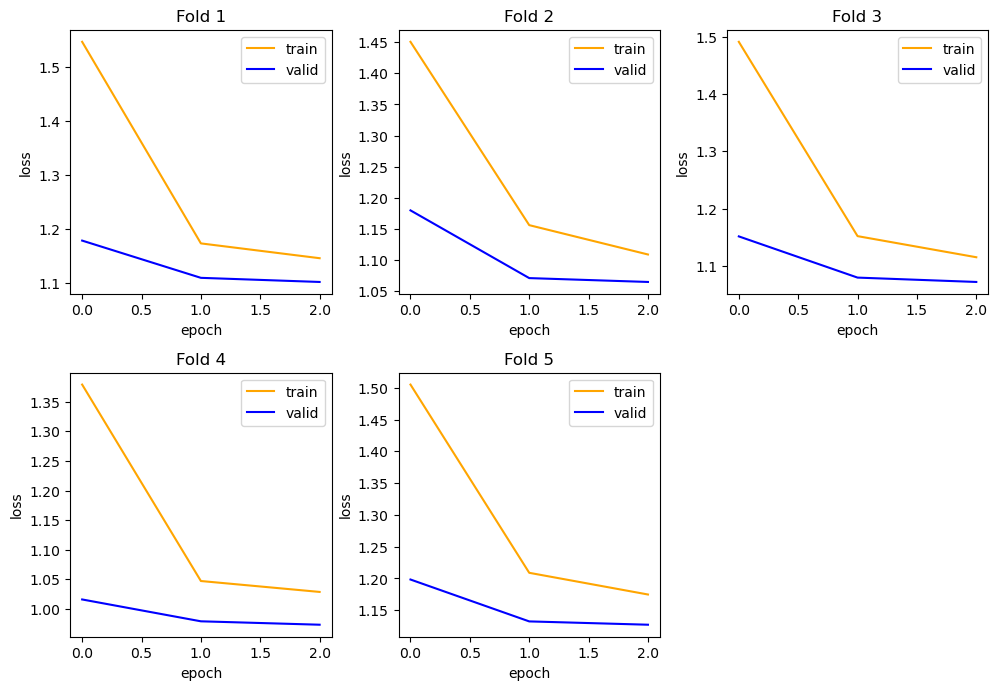

In [16]:
if RUN_TRAINING and (TRAIN_ALL == False):
    # Set device
    if KAGGLE:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    else:
        device = LOCAL_DEVICE
    print(f'Using {device} device')

    # Cross validation
    folds = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)\
            .split(np.arange(grouped_df.shape[0]), grouped_df['image_id'].to_numpy())
    
    # For Visualization
    train_loss_list = []
    valid_loss_list = []

    for fold, (trn_idx, val_idx) in enumerate(folds):     
        print(f'==========Cross Validation Fold {fold+1}==========')   
        # Define matcher, weight, and loss. 
        # See https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/models/detr.py#L304
        matcher = HungarianMatcher()
        weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
        losses = ['labels', 'boxes', 'cardinality']

        # Load Data
        train_loader, valid_loader = create_dataloader(grouped_df, marking, trn_idx, val_idx)

        # Load model, loss function, optimizing algorithm, and scheduler
        model = DETRModel().to(device)
        criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses).to(device) # eos_coef is used in the output layer to affect the output corresponding to the absence of an object.
        optimizer = optim.Adam(model.parameters(), lr=LR)
        scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)
                
        # For Visualization
        train_losses = []
        valid_losses = []

        # Start training
        best_loss = 10**5
        for epoch in range(EPOCHS):
            time_start = time.time()
            print(f'==========Epoch {epoch+1} Start Training==========')
            model.train()
            # criterion.train()
            train_loss = AverageMeter()
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for step, (imgs, targets, image_ids) in pbar:
                # print('.', end='') # Sometimes progress bars do not emerge on the notebook. In in the case, remove hash
                img_list = list(img.to(device) for img in imgs)
                targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
                
                output = model(img_list)
                
                loss_dict = criterion(output, targets)
                weight_dict = criterion.weight_dict

                losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                train_loss.update(losses.item(), BATCH_SIZE)         

            print(f'==========Epoch {epoch+1} Start Validation==========')
            
            with torch.no_grad():
                valid_loss = AverageMeter() 
                preds = []
                pbar = tqdm(enumerate(valid_loader), total=len(valid_loader))
                for step, (imgs, targets, image_ids) in pbar:
                    img_list = list(img.to(device) for img in imgs)
                    targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

                    output = model(img_list)

                    loss_dict = criterion(output, targets)
                    weight_dict = criterion.weight_dict

                    val_losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
                    valid_loss.update(val_losses.item(), BATCH_SIZE)
            scheduler.step()

            # print results from this epoch
            exec_t = int((time.time() - time_start)/60)
            print(
                f'Epoch : {epoch+1} - loss : {train_loss.avg:.4f} - val_loss : {valid_loss.avg:.4f} / Exec time {exec_t} min\n'
            )

            # For visualization
            train_losses.append(train_loss.avg)
            valid_losses.append(valid_loss.avg)
        
        train_loss_list.append(train_losses)
        valid_loss_list.append(valid_losses)
        del model, optimizer, train_loader, valid_loader, scheduler, train_losses, valid_losses
        gc.collect()
        torch.cuda.empty_cache()
    
    show_validation_score(train_loss_list, valid_loss_list)


### Train on All Data

After finding **the best number of epochs and hyperparameters** through cross-validation, the final step is **to train the model using all available data**.

To simplify the process and avoid errors, **combining the code for cross-validation and training on all data into a single script can be helpful**. This approach streamlines the workflow and makes it easier to transition from cross-validation to training with all data.

**Before running the following cell, please set `RUN_TRAINING = True` and `TRAIN_ALL = True` in the `Set Config` section.**

In [17]:
if RUN_TRAINING and TRAIN_ALL:
    # Set device
    if KAGGLE:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    else:
        device = LOCAL_DEVICE
    print(f'Using {device} device')
    
    matcher = HungarianMatcher()
    weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
    losses = ['labels', 'boxes', 'cardinality']
        
    # Load Data
    train_datasets = WheatDataset(grouped_df['image_id'].to_numpy(), marking, DATA_DIR+'train/', transforms=transform_train())
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True, multiprocessing_context='fork')

    # Load model, loss function, optimizing algorithm, and scheduler
    model = DETRModel().to(device)
    criterion = SetCriterion(NUM_CLASSES-1, matcher, weight_dict, eos_coef = NULL_CLASS_COEF, losses=losses).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)
            
    # Start training
    best_loss = 10**5
    for epoch in range(EPOCHS):
        time_start = time.time()
        print(f'==========Epoch {epoch+1} Start Training==========')
        model.train()
        criterion.train()
        train_loss = AverageMeter()
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for step, (imgs, targets, image_ids) in pbar:
            # print('.', end='') # Sometimes progress bars do not emerge on the notebook. In in the case, remove hash
            img_list = list(img.to(device) for img in imgs)
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
            
            output = model(img_list)
            
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()  

            train_loss.update(losses.item(), BATCH_SIZE)      

        scheduler.step()

        # print result from this epoch
        exec_t = int((time.time() - time_start)/60)
        print(
            f'Epoch : {epoch+1} - loss : {train_loss.avg:.4f} / Exec time {exec_t} min\n'
        )    

    print(f'Save model trained with all data')
    os.makedirs(MODEL_DIR, exist_ok=True)
    torch.save(model.state_dict(), MODEL_DIR+'objectdetection.pth')           

    del model, optimizer, train_loader, scheduler
    gc.collect()
    torch.cuda.empty_cache()

Creating a final model using the parameters obtained from cross-validation could increase our confidence that the deep learning model is optimized for the specific task at hand. 

Remember that **deep learning models may require adjustments or retraining when new data becomes available or if the task requirements change**. This is especially important to keep in mind when working on your own projects.

## Run Inference of Test Data

The input data structure for testing differs from that of training, therefore the Dataset class needs to be re-defined.

**Before running the following cells, please set `RUN_INFERENCE = True` in the `Set Config` section.**

In [18]:
def transform_test():
    transforms = [
        A.Resize(512,512,p=1),
        ToTensorV2(p=1)
    ]
    return A.Compose(transforms)


class WheatTestDataset(Dataset):
    def __init__(self, image_ids, data_root, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.data_root = data_root
        self.transforms = transforms

    def __len__(self):
        return self.image_ids.shape[0]
    
    def __getitem__(self, index):
        image_id = self.image_ids[index][:-4]
        # Load images
        image  = load_img(f'{self.data_root}{image_id}.jpg').astype(np.float32)
        image /= 255.0 # normalization

        # Transform images
        if self.transforms:
            # image = self.transforms(image)['image']
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id

Then, run inference.

In [19]:
if RUN_INFERENCE:
    submission_df = pd.DataFrame()   
    image_id_list = list(os.listdir(DATA_DIR+'test/'))
    submission_df['image_file'] = image_id_list
    submission_df['image_id'] = [image[:-4] for image in image_id_list]
    submission_df['PredictionString'] = ''
    
    if KAGGLE:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    else:
        device = LOCAL_DEVICE 
    print(f'Using {device} device')

    # Load Data
    test_datasets = WheatTestDataset(submission_df['image_file'].to_numpy(), DATA_DIR+'test/', transforms=transform_test())

    # Data Loader
    test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=False, multiprocessing_context='fork')

    # Load model
    model = DETRModel().to(device)
    model.load_state_dict(torch.load(MODEL_DIR+'objectdetection.pth'))

    # Start Inference
    print(f'==========Start Inference==========')
    with torch.no_grad():
        pbar = tqdm(enumerate(test_loader), total=len(test_loader))
        for step, (imgs, image_ids) in pbar:
            img_list = list(img.to(device) for img in imgs)
            output = model(img_list)
            for i, image_id in enumerate(image_ids):
                pred_str = ''
                prediction_scores = output['pred_logits'][i].softmax(1).detach().cpu().numpy()[:,0]
                predicted_boxes = output['pred_boxes'][i].detach().cpu().numpy()

                # _, h, w = imgs[0].shape
                h,w,_ = load_img(f'{DATA_DIR}test/{image_id}.jpg').shape # height, width, color of origianl image
                denormalized_boxes = denormalize_bbox(predicted_boxes, rows=h, cols=w)

                for box, p in zip(denormalized_boxes, prediction_scores):
                    if p > THRESHOLD:
                        score = p
                        pred_str += f'{score} {int(box[0])} {int(box[1])} {int(box[2])} {int(box[3])} '
                submission_df.loc[submission_df['image_id'] == image_id, 'PredictionString'] = pred_str
    print(submission_df.head())
else:
    print('RUN_INFERENCE is False')

RUN_INFERENCE is False


Save inference result.

In [20]:
if RUN_INFERENCE:
    if KAGGLE:
        submission_df.to_csv('submission.csv', index=False)
    else:
        submission_df.to_csv(CSV_SAVE_DIR+f'classification_test.csv')

else:
    print('RUN_INFERENCE is False')

RUN_INFERENCE is False


## Visualize One Prediction Example

Let's visual one prediction example.

In [21]:
if RUN_INFERENCE:
    target = submission_df.iloc[0]
    img = load_img(DATA_DIR+'test/'+target['image_file']).copy()
    prediction_results = target['PredictionString'].split(' ')
    num_bbox = len(prediction_results)//5

    for i in range(num_bbox):
        x = int(prediction_results[i*5+1])
        y = int(prediction_results[i*5+2])
        w = int(prediction_results[i*5+3])
        h = int(prediction_results[i*5+4])
        cv2.rectangle(img,
                    (x, y),
                    (x+w, y+h),
                    [255,0,0], 3)
    plt.imshow(img)

else:
    print('RUN_INFERENCE is False')

RUN_INFERENCE is False


## To Improve the Model

It seems that our object detection model works fairly well.

There are various techniques that can be employed to further enhance its performance, such as:

- **Incorporating a wider range of data augmentation techniques**
- **Implementing a more complex model architecture**
- **Performing thorough hyperparameter tuning**
- **Using ensembling methods**
- and more.

It is important to bear in mind that the effectiveness of these techniques is highly dependent on the specifics of the object detection task at hand, including the available data. A combination of multiple techniques may be necessary to achieve the desired level of performance.

I hope that this notebook has been informative and helpful in building an object detection model. I wish you the best of luck in all of your future modeling endeavors!

## Acknowledgement

I thank to [Matchan from YouTube Channel - Engawa AI Research Institute](https://www.youtube.com/channel/UCRwO-ewBHhNiC4qBEppi_JQ) and Mr. Masaaki Aiba for valuable discussion.


## References

- [End-to-End Object Detection with Transformers](https://arxiv.org/abs/2005.12872) ... Original paper of DETR
- [PyTorch](https://pytorch.org/)
	- [PyTorch - SAVING AND LOADING MODELS](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
- [PyTorch Hub](https://pytorch.org/hub/)
    - [PyTorch/Docs/torch.hub](https://pytorch.org/docs/stable/hub.html)
- [Albumentations](https://albumentations.ai/)
- [GitHub/facebookresearch/detr](https://github.com/facebookresearch/detr)
- [End to End Object Detection with Transformers:DETR](https://www.kaggle.com/code/tanulsingh077/end-to-end-object-detection-with-transformers-detr#Wheat-Detection-Competition-With-DETR)
- [GitHub/albumentations-team/albumentations#spatial-level-transforms](https://github.com/albumentations-team/albumentations#spatial-level-transforms)
- [Albumentations Documentation/Bounding boxes augmentation for object detection](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#bounding-boxes-augmentation)